## 1. Definizione imports

In [1]:
#roba generica
import numpy as np
from pathlib import Path
from PIL import Image

#gestione dataframe
import pandas as pd

#per grafici
import cv2 as cv
import matplotlib.pyplot as plt

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#usati da albumentations, contengono modelli e trasformazioni popolari
import torchvision
import torchvision.models as models
from torchvision.transforms.functional import to_grayscale
from torchvision.utils import make_grid

#modifica immagini (colorazione, blur, ecc ecc)
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

#metriche di bontà
#from sklearn.metrics import accuracy_score, roc_auc_score

#barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

#reti preaddestrate di efficientnet
from efficientnet_pytorch import EfficientNet

#Modello personalizzato della nostra rete neurale
from ConcreteModel import ConcreteModel

## 2. Definizione Variabili

### Definizione variabili generiche

In [2]:
#VARIABILE DI TEST PER ESEGUIRE IL TAGLIO AL DATASET (IL TRAINING DIVENTA MOLTO LUNGO ALTRIMENTI, ED è GIUSTO COSì)
#SERVE SOLO X TESTARE IL FUNZIONAMENTO DI TUTTE LE FUNZIONI
CUT_TRAINING = True

#----- VARIABILI PER I PERCORSI DEL DATASET -----
#path per la classe negativa (senza crepe)
#ds_normal = Path('../../Dataset/Default/surface-crack-detection/Negative')
DS_PATH_NORMAL = Path('C:/Users/gianl/Downloads/Concrete Crack Images for Classification/Negative')

#path per la classe positiva (con le crepe)
#ds_cracks = Path('../../Dataset/Default/surface-crack-detection/Positive')
DS_PATH_CRACKS = Path('C:/Users/gianl/Downloads/Concrete Crack Images for Classification/Positive')

#path per il percorso in cui andrò a salvare i parametri del modello
#le estensioni standard sono .pt e .pth
MODEL_SAVE_PATH= Path('./Test_Model_Params.pt')
#------------------------------------------------

#----- VARIABILI PER IL DATAFRAME -----
#Dimensione del training set: valori accettabili da 0 a 1 (in genere si prende l'80/85%)
training_set_size = 0.80
#seed per il random
rseed = 123

#variabili che indicano il nome delle due colonne del dataset
c_filepath = "filepath"
c_cracks = "cracks"
#--------------------------------------

#----- VARIABILI PER IL DATALOADER -----
#Valori di default che eseguono il caricamento in modalità non multi-threaded
#non modificare questi valori, decommentare le righe sotto e cambiare il valore la.
DL_TRAINING_N_WORKERS = 0
DL_VALIDATION_N_WORKERS = 0

#in caso di errori di pipeline broken, COMMENTARE QUESTE DUE RIGHE DI CODICE CON #
#DL_TRAINING_N_WORKERS = 4
#DL_VALIDATION_N_WORKERS = 3
#---------------------------------------

#PRINT VALORE VARIABILI
print("----- Paths -----")
print("Path Dataset Normal: " + str(DS_PATH_NORMAL))
print("Path Dataset Cracks: " + str(DS_PATH_CRACKS))
print("Path Model Params: " + str(MODEL_SAVE_PATH))
print("\n----- DataLoader -----")
print("Training # Workers: " + str(DL_TRAINING_N_WORKERS))
print("Validation # Workers: " + str(DL_VALIDATION_N_WORKERS))
print("\n----- Dataset Size -----")
print("Training set Dimension: " + str(training_set_size * 100) + "%")

----- Paths -----
Path Dataset Normal: C:\Users\gianl\Downloads\Concrete Crack Images for Classification\Negative
Path Dataset Cracks: C:\Users\gianl\Downloads\Concrete Crack Images for Classification\Positive
Path Model Params: Test_Model_Params.pt

----- DataLoader -----
Training # Workers: 0
Validation # Workers: 0

----- Dataset Size -----
Training set Dimension: 80.0%


### Definizione variabili della Rete

In [3]:
#BATCH SIZE, SE SI HA PIù RAM, SI PUò AUMENTARE PER VELOCIZZARE, ALTRIMENTI SI PUò RIDURRE SE SI HA POCA RAM
#Default: 64
batch_size = 256
BS = batch_size

#EPOCHE DI TRAINING (!!> 0) in genere si tiene 5-10-15, ecc ecc...
training_epoques = 5
TE = training_epoques

#LEARNING RATE
learning_rate = 1e-2
LR = learning_rate

#WEIGHT DECAY
weight_decay = 0.01
WD = weight_decay

# Flag for feature extracting.
# When False, we finetune the whole model
# When True we block the backbone and update only the new layers.
#           we update the backbone layers after the 'feature_training_from_layer' param value
feature_extract = True

# Se feature_extract = True, posso indicare da che layer della backbone eseguire il finetuning
# Se -1 il backbone non viene allenato
# Se 0 è come se avessimo metto feature_extract = False e dunque la rialleno da 0
feature_training_from_layer = -1

# Nome della rete EfficientNet da utilizzare
network_model_name = "efficientnet-b0"
#efficientnet-b0: 213 backbone params
#efficientnet-b1: 301 backbone params
#efficientnet-b2: 301 backbone params
#efficientnet-b4: 418 backbone params
# come consiglio conviene al massimo usare b3 (poi dopo i parametri aumentano di moltissimo e l'accuracy sale di poco)
# giustamente se si ha una buona gpu si può anche salire fino a b8 che è l'ultimo modello (attualmente: 17/12/2020)

###################################################
#LOSS FUNCTION
loss_fn = F.binary_cross_entropy_with_logits
###################################################

#PRINT VALORE VARIABILI RETE
print("----- Network Training Params -----")
print("Batch size: " + str(BS))
print("Learning Rate: " + str(LR))
print("Weight Decay: " + str(WD))
print("Selected Loss Function: " + str(loss_fn).split("at")[0][1:])

print("\n----- Finetuning -----")
if not feature_extract:
    print("Finetune not activated. Training from scratch of the whole Network")
else:
    if feature_training_from_layer == 0:
        print("Finetune not activated. Training from scratch of the whole Network")
    else:
        if feature_training_from_layer == -1:
            print("Finetune activated only on the new classifier")
        else:
            print("Finetune activated from backbone layer: ", str(feature_training_from_layer))

----- Network Training Params -----
Batch size: 256
Learning Rate: 0.01
Weight Decay: 0.01
Selected Loss Function: function binary_cross_entropy_with_logits 

----- Finetuning -----
Finetune activated only on the new classifier


## 3. Preparazione Data

### Caricamento dei dataset

In [4]:
train_data = [(o,0) for o in DS_PATH_NORMAL.iterdir()]
train_data_cracks = [(o,1) for o in DS_PATH_CRACKS.iterdir()]
train_data.extend(train_data_cracks)

train_data = pd.DataFrame(train_data, columns=[c_filepath, c_cracks])

### Generazione Training set e Validation set

In [42]:
np.random.seed(rseed)
msk = np.random.rand(len(train_data)) < training_set_size

train_df = train_data[msk].reset_index()
test_df = train_df[16030:16039]
val_df = train_data[~msk].reset_index()

############################################################################
#TAGLIO IL DATASET SE INDICATO ALL'INIZIO (RAGIONI DI TEST DEL CODICE)
if CUT_TRAINING == True:
    print("Elements Training set Before Cutting: " + str(len(train_df)))
    print("Elements Validation set Before Cutting: " + str(len(val_df)))
    #DROP IN 3 PARTI
    #DROP CENTRALE
    train_df = train_df.drop(train_df.index[11000:25000])
    val_df = val_df.drop(val_df.index[400:3000])
    #DROP ALLA FINE
    train_df = train_df.drop(train_df.index[5500:14000])
    val_df = val_df.drop(val_df.index[2000:5000])
    #DROP ALL'INIZIO
    train_df = train_df.drop(train_df.index[300:9068])
    val_df = val_df.drop(val_df.index[100:2332])
    print("----------------------------------------")
############################################################################

#PRINT VALORE DIMENSIONI TRAINING SET E VALIDATION SET
print("Elements Training set: " + str(len(train_df)))
print("Elements Validation set: " + str(len(val_df)))

Elements Training set Before Cutting: 32068
Elements Validation set Before Cutting: 7932
----------------------------------------
Elements Training set: 800
Elements Validation set: 100


## 4. Visualizzazione Immagini dei due set di dati

In [6]:
#Numero di immagini da mostrare
plots = 4
#dimensioni delle immagini
#altezza
plots_height = 20
#larghezza
plots_width = 20

### Immagini senza crepe

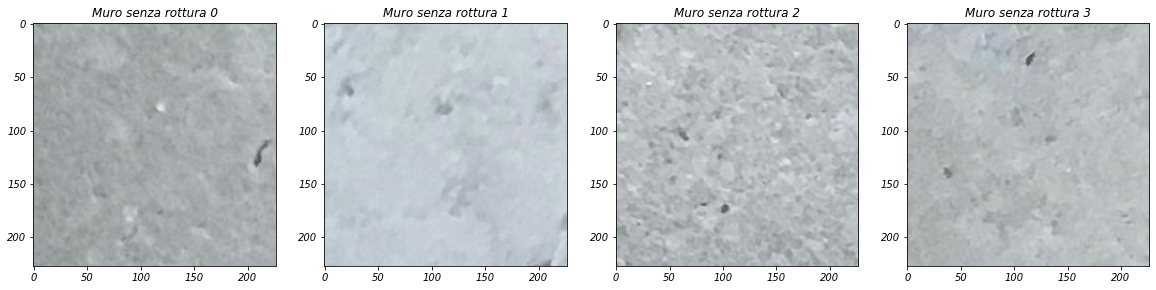

In [7]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
for i in range(plots):
    a[i].imshow(cv.imread(str(train_data.iloc[i][c_filepath])))
    a[i].set_title("Muro senza rottura " + str(i))

### Immagini con le crepe

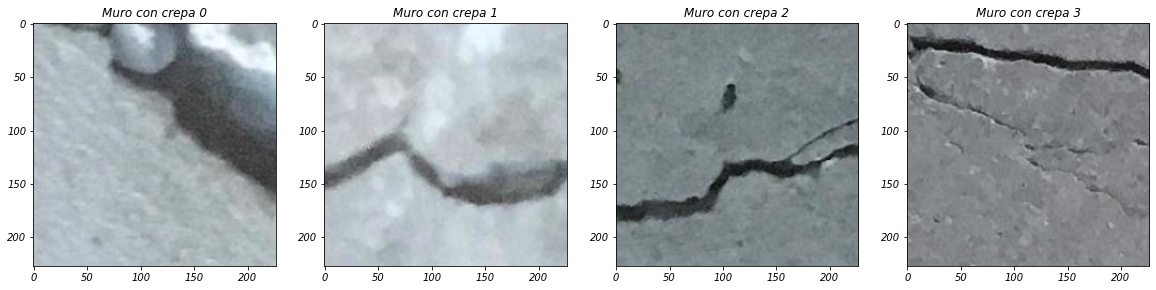

In [8]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
for i in range(-plots, 0):
    a[i].imshow(cv.imread(str(train_data.iloc[i][c_filepath])))
    a[i].set_title("Muro con crepa " + str(plots + i))

## 5. Dataset Transformation

### Dataset personalizzato, applica delle trasformazioni alle immagini prese in input

In [9]:
#Questa classe permette di gestire il dataset di partenza, a cui però applico delle trasformazioni
#Se si vuole usare il dataset originario basta passare il dataframe di partenza.
class ConcreteDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        #row = self.df.iloc[idx]
        img = Image.open(self.df.iloc[idx][c_filepath])
        
        if self.transforms:
            #when using albumation we have to pass data as dictionary to transforms.
            #The output after transformation is also a dictionary
            #we need to take the value from dictionary. That is why we are giving an image at the end.
            img = self.transforms(**{"image": np.array(img)})["image"]
        
        if self.is_test:
            return img
        else:
            cracks_tensor = torch.tensor([self.df.iloc[idx][c_cracks]], dtype=torch.float32)
            return img, cracks_tensor

### Definizione delle trasformazioni da applicare ai due dataset (training e test)

In [10]:
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
#Trasformazioni per il set di training
train_tfms = A.Compose(
    [
        A.Cutout(p = 0.5),
        A.RandomRotate90(p = 0.5),
        A.Flip(p = 0.5),
        ToTensor(normalize = imagenet_stats)
    ])
#Trasformazioni x il set di test
test_tfms = A.Compose(
    [
        ToTensor(normalize = imagenet_stats)
    ])

### Test funzionamento ConcreteDataset e DataLoader + esempio di come prendere i dati dal DataLoader

In [11]:
train_ds = ConcreteDataset(train_df, transforms = train_tfms)
val_ds = ConcreteDataset(val_df, transforms = test_tfms, is_test = True)
print(len(train_ds), ",", len(val_ds))

train_dl = DataLoader(train_ds, batch_size = BS, shuffle = True, num_workers = DL_TRAINING_N_WORKERS, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = BS, num_workers = DL_VALIDATION_N_WORKERS, pin_memory = True)
xb, yb = next(iter(train_dl))
#POSSO USARE XB ED YB PER DARLI IN PASTO ALLA RETE
print(xb.shape, ",", yb.shape)

800 , 100
torch.Size([256, 3, 227, 227]) , torch.Size([256, 1])


## 6. Training della rete

### Metodi per il training

In [12]:
#Device in uso (cuda = GPU)
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Metodo che ritorna una nuova copia del modello
def get_model(model_name='efficientnet-b0', lr=1e-5, wd=0.01, feature_extracting=False, feature_training_from = -1, opt_fn=torch.optim.AdamW, device=None):
    device = device if device else get_device()
    model = ConcreteModel(eff_name = model_name)
    
    #Se feature_training_from = 0, rialleno tutto il backbone, dunque non imposto a False i requires_grad dei layer
    if feature_extracting and feature_training_from != 0:
        cont = 0
        for parameter in model.backbone.parameters():
            #Se feature_training_from = -1 allora congelo completamente il backbone
            #Se feature_training_from > 0, congelo tutti i layer che precedono questo valore, mentre gli altri li alleno
            if feature_training_from == -1 or cont < feature_training_from:
                parameter.requires_grad = False
            cont = cont + 1
                
    opt = opt_fn(model.parameters(), lr=lr, weight_decay=wd)
    model = model.to(device)
    return model, opt

def training_step(xb, yb, model, loss_fn, opt, device, scheduler):
    xb ,yb = xb.to(device), yb.to(device)
    out = model(xb)
    opt.zero_grad()
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()
    scheduler.step()
    return loss.item()
    
def validation_step(xb, yb, model, loss_fn, device):
    xb, yb = xb.to(device), yb.to(device)
    out = model(xb)
    loss = loss_fn(out, yb)
    out = torch.relu(out)#torch.sigmoid(out)
    return loss.item(), out

def get_data(train_df, valid_df, test_df, train_tfms, test_tfms, bs):
    train_ds = ConcreteDataset(df = train_df, transforms = train_tfms)
    valid_ds = ConcreteDataset(df = valid_df, transforms = test_tfms)
    test_ds = ConcreteDataset(df = test_df, transforms = test_tfms)
    train_dl = DataLoader(dataset = train_ds, batch_size = bs, shuffle = True, num_workers = DL_TRAINING_N_WORKERS)
    valid_dl = DataLoader(dataset = valid_ds, batch_size = bs*2, shuffle = False, num_workers = DL_VALIDATION_N_WORKERS)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs*2, shuffle = False, num_workers = DL_VALIDATION_N_WORKERS)
    return train_dl, valid_dl, test_dl

In [13]:
def fit(epochs, model, train_dl, valid_dl, opt, loss_fn, device=None):
    
    device = device if device else get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    #val_rocs = []
    tloss = []
    vloss = []
    training_accuracy = []
    
    #Creating progress bar
    data_table = master_bar(range(epochs))
    data_table.write(['epoch', 'train_loss', 'valid_loss', 'accuracy(%)'],table=True)

    for epoch in data_table:    
        trn_loss, val_loss = 0.0, 0.0
        val_preds = np.zeros((len(valid_dl.dataset), 1))
        val_targs = np.zeros((len(valid_dl.dataset), 1))
        
        #Training
        model.train()
        
        #For every batch 
        for xb, yb in progress_bar(train_dl, parent = data_table):
            trn_loss += training_step(xb, yb, model, loss_fn, opt, device, scheduler) 
        trn_loss /= data_table.child.total
        tloss.append(trn_loss)

        #Validation
        model.eval()
        with torch.no_grad():
            for i,(xb, yb) in enumerate(progress_bar(valid_dl, parent = data_table)):
                loss, out = validation_step(xb, yb, model, loss_fn, device)
                val_loss += loss
                bs = xb.shape[0]
                val_preds[i*bs : i*bs+bs] = out.cpu().numpy()
                val_targs[i*bs : i*bs+bs] = yb.cpu().numpy()
                
        #NORMALIZZO ACCURACY
        val_preds_normalized = np.where(val_preds > 0.5, 1, 0)
        val_accuracy = np.count_nonzero((val_preds_normalized - val_targs) == 0) / len(val_targs) * 100
        training_accuracy.append(val_accuracy)
        
        val_loss /= data_table.child.total
        vloss.append(val_loss)
        #val_roc = roc_auc_score(val_targs.reshape(-1), val_preds.reshape(-1))
        #val_rocs.append(val_roc)

        data_table.write([epoch, f'{trn_loss:.4f}', f'{val_loss:.4f}', f'{val_accuracy:.2f}'], table=True)
    return model, tloss, vloss, training_accuracy

### Caricamento dei dataset

In [43]:
train_dl, valid_dl, test_dl = get_data(train_df, val_df, test_df, train_tfms, test_tfms, BS)

### Caricamento pesi dalla rete pre-allenata

In [15]:
%%time
model, opt = get_model(model_name=network_model_name, feature_extracting=feature_extract, feature_training_from=feature_training_from_layer, lr=LR, wd=WD)

cont = 0
for p in model.backbone.parameters():
    cont+=1
print("Model backbone 'params': ", cont)


Loaded pretrained weights for efficientnet-b0
----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  1280
Input features 2° Linear:  640
Input features 3° Linear:  320
Output 3° Linear:  1
------------------------
Model backbone 'params':  213
Wall time: 150 ms


### Training effettivo della rete

In [16]:
%%time
model, train_loss, valid_loss, trains_accuracy = fit(TE, model, train_dl, valid_dl, opt, loss_fn)

epoch,train_loss,valid_loss,accuracy(%)
0,16.9155,0.1697,99.00
1,0.7500,3.4853,12.00
2,0.7443,0.1697,98.00
3,0.9347,0.1873,98.00
4,0.4630,0.2251,97.00


Wall time: 6min 36s


## 7. Plot risultati del Training

### Plot Training Loss

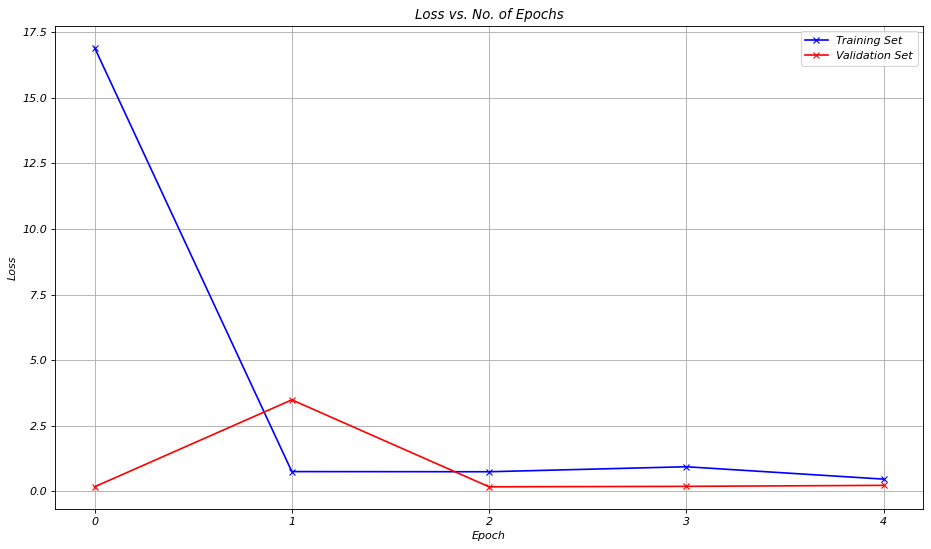

In [17]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.title('Loss vs. No. of Epochs');
plt.grid()

### Plot Training Accuracy

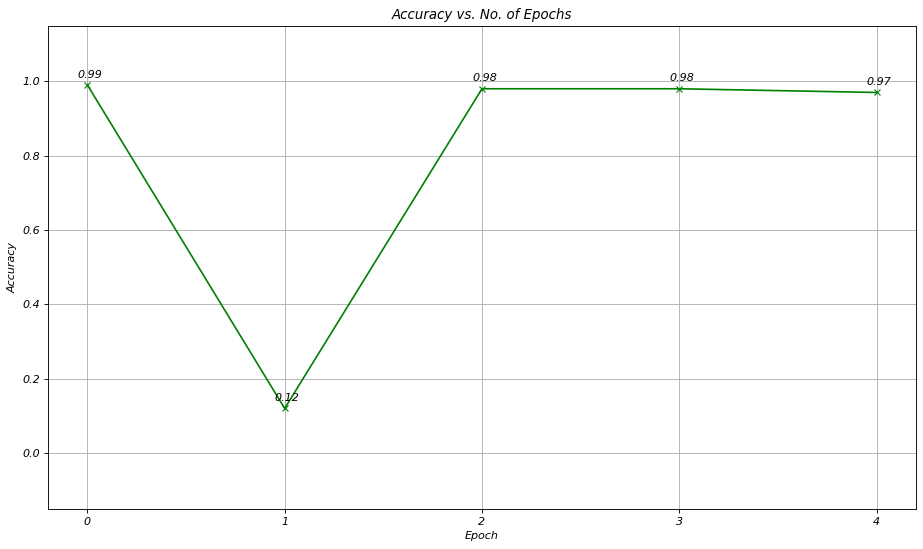

In [18]:
#NORMALIZZO DA 0 A 1 E TOGLIO I NUMERI DOPO 2 POSIZIONI NELLA VIRGOLA
trains_accuracy_normalized = np.array(np.round(trains_accuracy,2)) / 100
#FIGURA
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(trains_accuracy_normalized, '-gx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Accuracy')
plt.ylim(-0.15, 1.15)
plt.title('Accuracy vs. No. of Epochs');
plt.grid()
#NUMERINI SULLA GRIGLIA
for x,y in zip(trains_accuracy_normalized, range(0, len(trains_accuracy_normalized))):
    plt.annotate(str(x),xy=(y-0.05 ,x + 0.02))

## 8. Salvataggio del Modello

### Print delle informazioni del Modello e dell'Optimizer

In [19]:
#Print informazioni del modello
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
#Print informazioni dell'ottimizzatore
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

Model's state_dict:
backbone._conv_stem.weight 	 torch.Size([32, 3, 3, 3])
backbone._bn0.weight 	 torch.Size([32])
backbone._bn0.bias 	 torch.Size([32])
backbone._bn0.running_mean 	 torch.Size([32])
backbone._bn0.running_var 	 torch.Size([32])
backbone._bn0.num_batches_tracked 	 torch.Size([])
backbone._blocks.0._depthwise_conv.weight 	 torch.Size([32, 1, 3, 3])
backbone._blocks.0._bn1.weight 	 torch.Size([32])
backbone._blocks.0._bn1.bias 	 torch.Size([32])
backbone._blocks.0._bn1.running_mean 	 torch.Size([32])
backbone._blocks.0._bn1.running_var 	 torch.Size([32])
backbone._blocks.0._bn1.num_batches_tracked 	 torch.Size([])
backbone._blocks.0._se_reduce.weight 	 torch.Size([8, 32, 1, 1])
backbone._blocks.0._se_reduce.bias 	 torch.Size([8])
backbone._blocks.0._se_expand.weight 	 torch.Size([32, 8, 1, 1])
backbone._blocks.0._se_expand.bias 	 torch.Size([32])
backbone._blocks.0._project_conv.weight 	 torch.Size([16, 32, 1, 1])
backbone._blocks.0._bn2.weight 	 torch.Size([16])
backbone.

backbone._blocks.8._bn2.weight 	 torch.Size([112])
backbone._blocks.8._bn2.bias 	 torch.Size([112])
backbone._blocks.8._bn2.running_mean 	 torch.Size([112])
backbone._blocks.8._bn2.running_var 	 torch.Size([112])
backbone._blocks.8._bn2.num_batches_tracked 	 torch.Size([])
backbone._blocks.9._expand_conv.weight 	 torch.Size([672, 112, 1, 1])
backbone._blocks.9._bn0.weight 	 torch.Size([672])
backbone._blocks.9._bn0.bias 	 torch.Size([672])
backbone._blocks.9._bn0.running_mean 	 torch.Size([672])
backbone._blocks.9._bn0.running_var 	 torch.Size([672])
backbone._blocks.9._bn0.num_batches_tracked 	 torch.Size([])
backbone._blocks.9._depthwise_conv.weight 	 torch.Size([672, 1, 5, 5])
backbone._blocks.9._bn1.weight 	 torch.Size([672])
backbone._blocks.9._bn1.bias 	 torch.Size([672])
backbone._blocks.9._bn1.running_mean 	 torch.Size([672])
backbone._blocks.9._bn1.running_var 	 torch.Size([672])
backbone._blocks.9._bn1.num_batches_tracked 	 torch.Size([])
backbone._blocks.9._se_reduce.weight 

### Salvataggio del Modello

In [20]:
#Salvataggio
torch.save(model.state_dict, MODEL_SAVE_PATH)

### Test della rete sul Test Set

9


[[ 0.      ]
 [27.60113 ]
 [24.00577 ]
 [27.576092]
 [20.00449 ]
 [27.761984]
 [38.37895 ]
 [19.652933]
 [34.129692]]


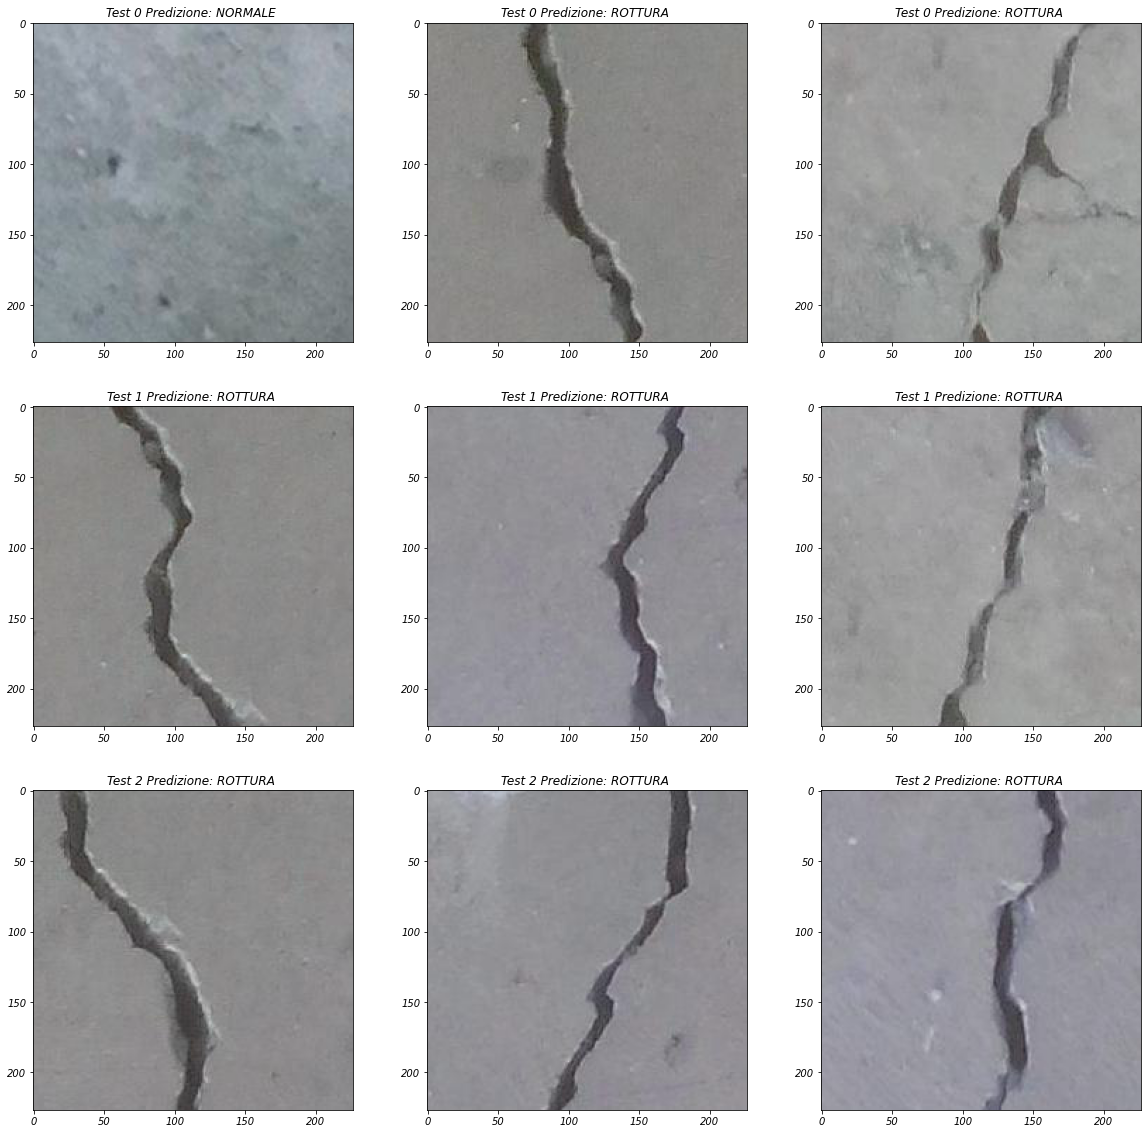

In [44]:
mtest = len(test_df)
print(mtest)

#imposto la rete in modalità evaluate
model.eval()
with torch.no_grad():
    for xb, yb in progress_bar(test_dl):
        out = model(xb)
        out = torch.relu(out).cpu().numpy()
        print(out)
        
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(3, 3)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
cont = 0
for i in range(0, 3):
    for j in range (0, 3):
        a[i][j].imshow(cv.imread(str(test_df.iloc[cont][c_filepath])))
        if(out[cont] > 0.5):
            a[i][j].set_title("Test " + str(i) + " Predizione: ROTTURA ")
        else:
            a[i][j].set_title("Test " + str(i) + " Predizione: NORMALE ")
        cont += 1
